In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt
import itertools
import copy

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [20]:
def HR_at_n(R,R_hat,R_exclude,n=10,testing=True):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): always test set
         R_hat (np.array): prediction
         R_exclude (np.array): train set
         n (int): length of recommendation
    returns:
         RMSE value
        
    """
    R_hat = copy.copy(R_hat)
    R_hat = {'users_id': R.dataset.users, 'item_id': R.dataset.items, "labels":torch.cat(([i for i in R_hat])).flatten()}
    R_hat = pd.DataFrame(R_hat)
    R_hat = np.array(pd.crosstab(index=pd.Categorical(R_hat['users_id'],categories = [i for i in range(1,943+1)]), 
                                                        columns=pd.Categorical(R_hat['item_id'],categories = [i for i in range(1,1682+1)]),
                                                        values=R_hat['labels'], aggfunc=np.sum, dropna= False).fillna(0).values)

    if testing == True:
      R = copy.copy(R)
      R = {'users_id': R.dataset.users, 'item_id': R.dataset.items, "labels":R.dataset.labels}
      R = pd.DataFrame(R)
      R = np.array(pd.crosstab(index=pd.Categorical(R['users_id'],categories = [i for i in range(1,943+1)]), 
                                                        columns=pd.Categorical(R['item_id'],categories = [i for i in range(1,1682+1)]),
                                                        values=R['labels'], aggfunc=np.sum, dropna= False).fillna(0).values)
      R_exclude = copy.copy(R_exclude)
      R_exclude = {'users_id': R_exclude.dataset.users, 'item_id': R_exclude.dataset.items, "labels":R_exclude.dataset.labels}
      R_exclude = pd.DataFrame(R_exclude)
      R_exclude = np.array(pd.crosstab(index=pd.Categorical(R_exclude['users_id'],categories = [i for i in range(1,943+1)]), 
                                                          columns=pd.Categorical(R_exclude['item_id'],categories = [i for i in range(1,1682+1)]),
                                                          values=R_exclude['labels'], aggfunc=np.sum, dropna= False).fillna(0).values)
    else:
      R = copy.copy(R_exclude)
      R = {'users_id': R.dataset.users, 'item_id': R.dataset.items, "labels":R.dataset.labels}
      R = pd.DataFrame(R)
      R = np.array(pd.crosstab(index=pd.Categorical(R['users_id'],categories = [i for i in range(1,943+1)]), 
                                                          columns=pd.Categorical(R['item_id'],categories = [i for i in range(1,1682+1)]),
                                                          values=R['labels'], aggfunc=np.sum, dropna= False).fillna(0).values)
      R_exclude = np.zeros_like(R)
    #YOUR TASK: implement HR@n function

    exclude_items_per_user = np.sum(R_exclude>0,axis=1)
    R_hat[R_exclude>0] = -np.inf
    pred_items = np.argsort(-R_hat,axis=1)
    true_items = np.argsort(-R,axis=1)
    test_items_cnt = np.sum(R>0,axis=1)
    hr_total = 0
    for user_id in range(pred_items.shape[0]):
      min_end = min(n,pred_items.shape[1]-exclude_items_per_user[user_id])
      pred_items_for_user = pred_items[user_id,:min_end]
      propper_items_cnt_for_user = np.sum(np.in1d(pred_items_for_user,true_items[user_id,:test_items_cnt[user_id]]))
      if test_items_cnt[user_id]>0:
        hr_for_user = propper_items_cnt_for_user/min(n,test_items_cnt[user_id])
        hr_total += hr_for_user
    hr_total /= np.shape(R)[0]
    return hr_total

In [8]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
model = NeuMF(users_num,movies_num,16,[128,64,32])
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
test_loss = []
train_loss = []
for epoch in range(50):
    model.train()
    tr_loss=[]
    print("Traininng "+str(epoch))
    for (u,i,l) in tqdm.tqdm(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        # calculate loss
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
    train_loss.append(np.mean(tr_loss))
    model.eval()
    predictions = []
    with torch.no_grad():
        t_loss=[]
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid=True)
            predictions.append(yhat)
            l = l.unsqueeze(1)
            tl = criterion(yhat, l)
            t_loss.append(tl) 
        test_loss.append(np.mean(t_loss))

Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 10


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 11


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 12


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 13


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Traininng 14


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Traininng 15


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 16


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


Traininng 17


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


Traininng 18


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Traininng 19


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 20


100%|██████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 21


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 22


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 23


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 24


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 25


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Traininng 26


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 27


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 28


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 29


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 30


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 31


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Traininng 32


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 33


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 34


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 35


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 36


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Traininng 37


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 38


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 39


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 40


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 41


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 42


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Traininng 43


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 44


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Traininng 45


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


Traininng 46


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Traininng 47


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 48


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Traininng 49


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


### Plot results

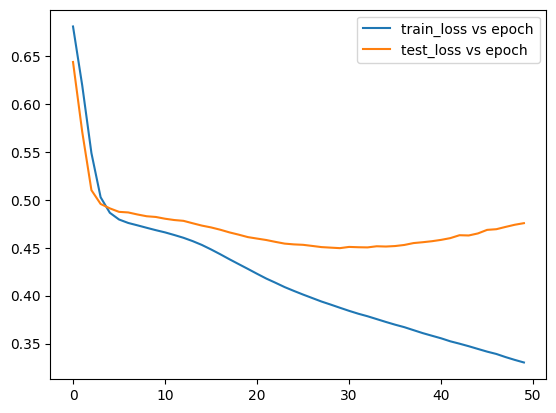

In [12]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()

### Your task
1. Find best HP of the model by crossvalidation
2. for every user provide the recommendation, calculate HR@10 (as in the previous excersise)

In [28]:
users_num = 943 + 1
movies_num = 1682 + 1

hyperpar = {'mf_dim': [8,16,32,64],
    'mlp_layer_sizes': [[64,32],[128, 64],[128,64,32]],
    'learning_rate': [0.01, 0.001],}
keys, values = zip(*hyperpar.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
loss_dic_all = []

for fold in range(1,6):
    loss_dic = []
    ds_train = ML100kDataset('ml-100k/u{}.base'.format(fold), 2)
    ds_test = ML100kDataset('ml-100k/u{}.test'.format(fold), 2)
    # create a data loader for train and test sets
    train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
    test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

    for test_hyper in permutations_dicts:
      model = NeuMF(users_num,movies_num,test_hyper['mf_dim'],test_hyper['mlp_layer_sizes'])
      criterion = nn.BCELoss()
      optimizer = Adam(model.parameters(), lr=test_hyper['learning_rate'])
      test_loss = []
      train_loss = []
      #10 epochs were used for faster computation time
      for epoch in range(10):
        model.train()
        tr_loss=[]
        print("Traininng "+str(epoch))
        for (u,i,l) in tqdm.tqdm(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(u,i,sigmoid=True)
            l = l.unsqueeze(1)
            # calculate loss
            loss = criterion(yhat, l)
            tr_loss.append(loss.detach().numpy())
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        train_loss.append(np.mean(tr_loss))
        model.eval()
        predictions = []
        with torch.no_grad():
            t_loss=[]
            for i, (u,i,l) in enumerate(test_dl):
                yhat = model(u, i, sigmoid=True)
                predictions.append(yhat)
                l = l.unsqueeze(1)
                tl = criterion(yhat, l)
                t_loss.append(tl) 
            test_loss.append(np.mean(t_loss))

      loss_dic.append([test_hyper,test_loss[-1]])
    loss_dic_all.append(np.array(loss_dic))

Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 7


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Traininng 3


100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Traininng 7


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


Traininng 8


100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


Traininng 9


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


Traininng 3


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 9


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Traininng 8


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Traininng 8


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Traininng 9


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Traininng 1


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Traininng 2


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Traininng 3


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Traininng 4


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 5


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 9


100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


Traininng 0


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Traininng 1


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 3


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Traininng 9


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Traininng 0


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Traininng 1


100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Traininng 2


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 4


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Traininng 5


100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Traininng 9


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 1


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Traininng 0


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 2


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Traininng 5


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Traininng 0


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Traininng 2


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Traininng 3


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Traininng 8


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Traininng 0


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Traininng 4


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Traininng 5


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 6


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 7


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Traininng 9


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Traininng 0


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Traininng 1


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Traininng 2


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 3


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 4


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Traininng 5


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 6


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Traininng 7


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Traininng 8


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 9


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Traininng 0


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 9


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 4


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 6


100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 9


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 1


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 9


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Traininng 7


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 0


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 2


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 5


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 6


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 9


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 2


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 4


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 4


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 5


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 9


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 8


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Traininng 9


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 1


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 6


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Traininng 3


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 3


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 9


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 6


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Traininng 7


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 2


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 8


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 9


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 4


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 7


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Traininng 8


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 7


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 9


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 9


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 1


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 5


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 1


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 7


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 0


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 1


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 0


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 7


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 0


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Traininng 1


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 9


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 2


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 0


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 7


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Traininng 8


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 6


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 1


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 5


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 7


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 9


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 5


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 1


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 5


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 9


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 3


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 1


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 8


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 6


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 1


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 4


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 7


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 0


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Traininng 1


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 8


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 6


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 2


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Traininng 7


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 8


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 7


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 9


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 4


100%|██████████| 15/15 [00:15<00:00,  1.00s/it]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 0


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 7


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Traininng 8


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 0


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 1


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 4


100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 6


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 0


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


Traininng 4


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 6


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 9


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


Traininng 3


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 5


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 7


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 8


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Traininng 1


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Traininng 2


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 1


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 2


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Traininng 3


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Traininng 4


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 5


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 7


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Traininng 8


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Traininng 9


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Traininng 0


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Traininng 1


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Traininng 2


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 5


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Traininng 6


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Traininng 2


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 5


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Traininng 0


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Traininng 2


100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Traininng 3


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Traininng 4


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 6


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 8


100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


Traininng 9


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 1


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Traininng 2


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Traininng 3


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 5


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 7


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Traininng 8


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Traininng 0


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Traininng 1


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Traininng 2


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Traininng 3


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Traininng 4


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Traininng 5


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Traininng 6


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Traininng 7


100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


Traininng 8


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Traininng 9


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


In [94]:
mean_loss = np.array(copy.copy(loss_dic))
mean_loss[:,1] = 0
for i in range(5):
  mean_loss[:,1] += loss_dic_all[i][:,1]
mean_loss[:,1]/=5

min_z = np.min(np.array(mean_loss)[:,1])
pos_min_z = np.argwhere(np.array(mean_loss)[:,1] == np.min(np.array(mean_loss)[:,1]))[0]

print("Results:")
print(mean_loss[pos_min_z[0]])
best_param = mean_loss[pos_min_z[0]][0]

Results:
[{'mf_dim': 8, 'mlp_layer_sizes': [64, 32], 'learning_rate': 0.01}
 0.4426321029663086]


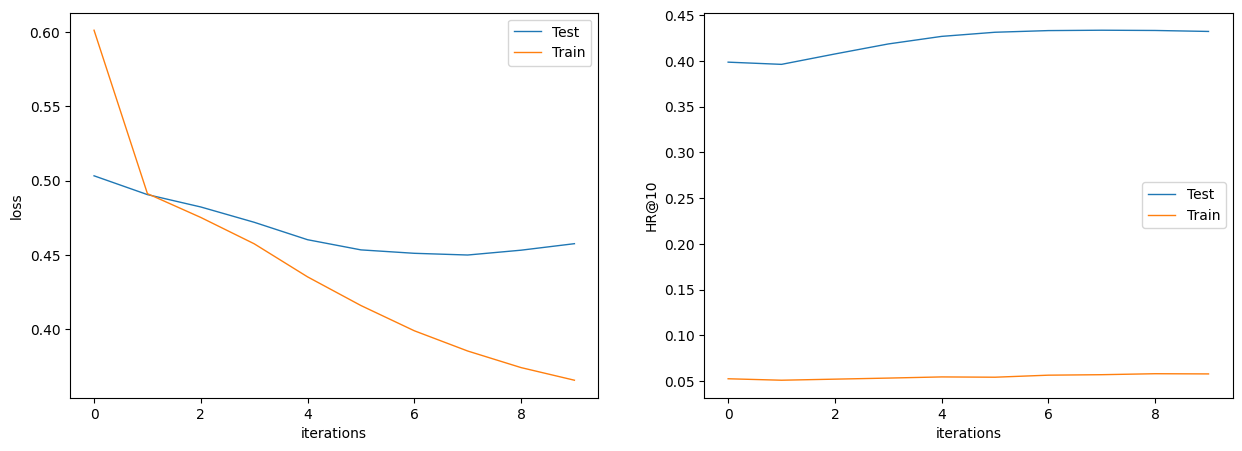

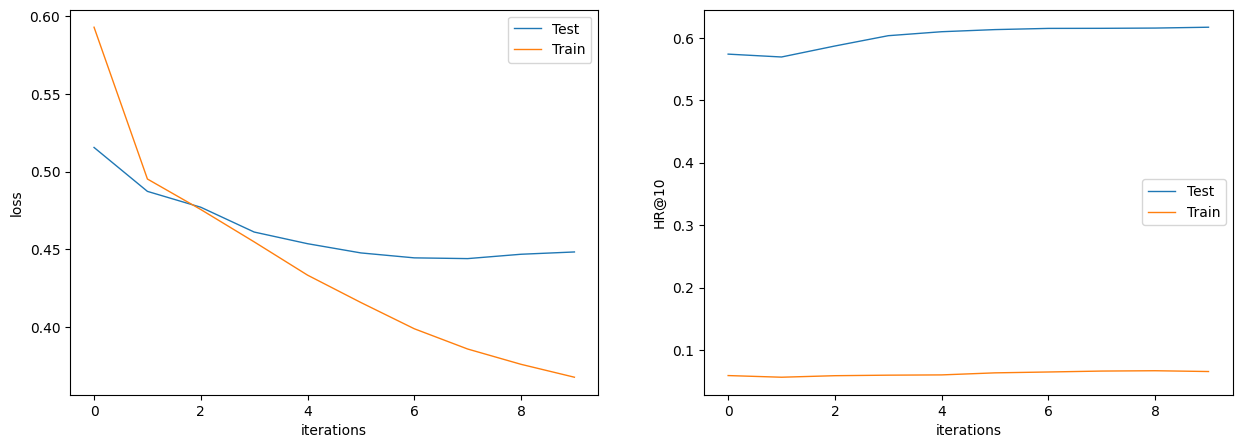

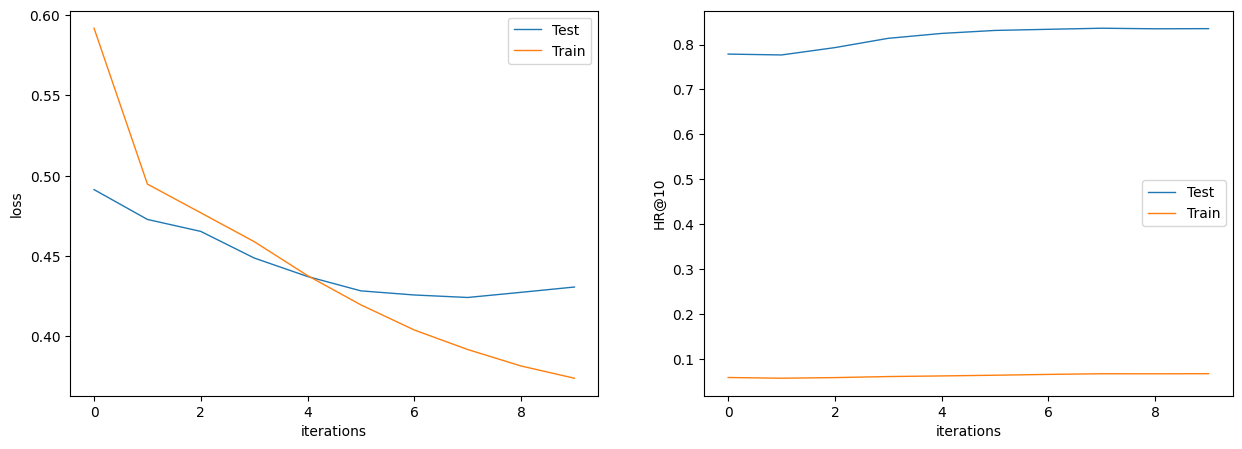

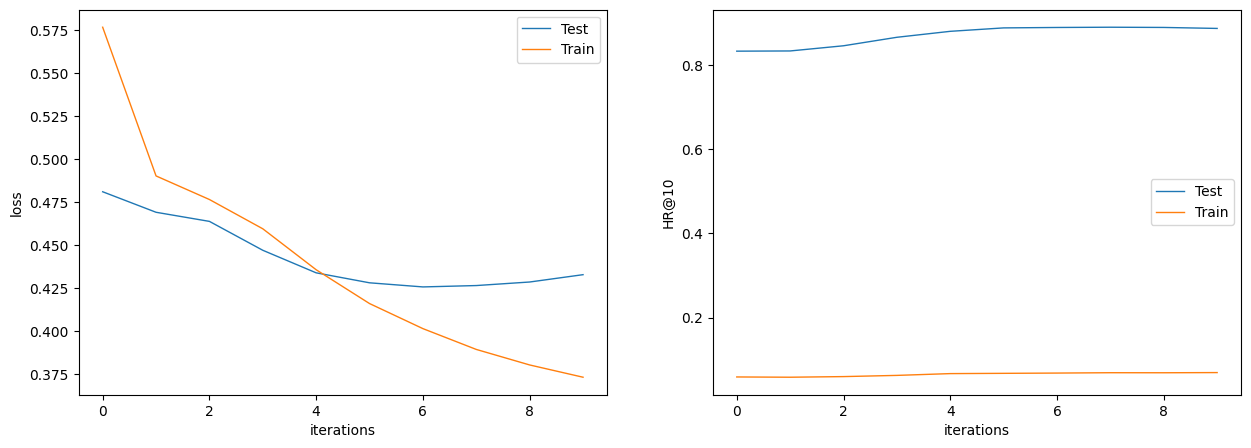

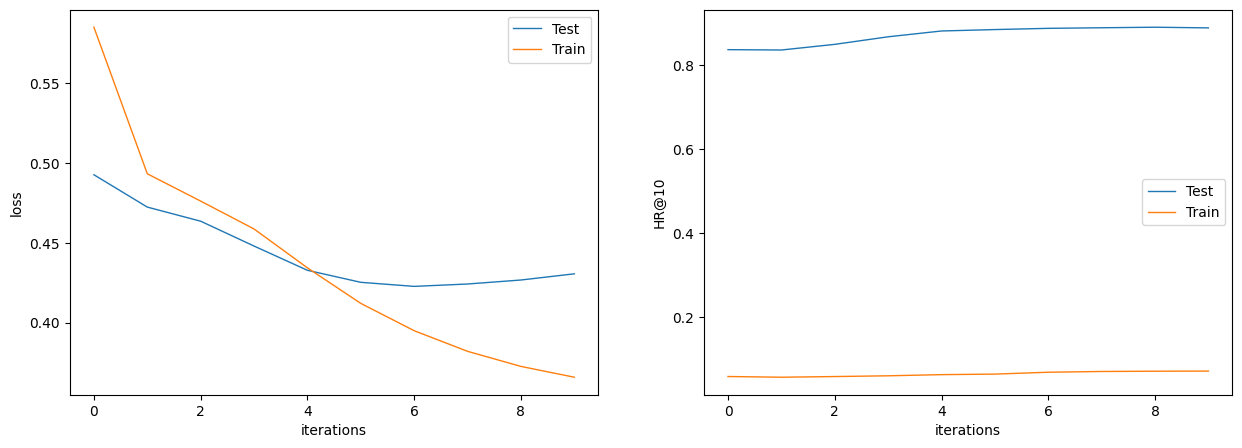

In [97]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1
for fold in range(1,6):
  ds_train = ML100kDataset('ml-100k/u{}.base'.format(fold), 2)
  ds_test = ML100kDataset('ml-100k/u{}.test'.format(fold), 2)
  # create a data loader for train and test sets
  train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
  test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
  model = NeuMF(users_num,movies_num,best_param['mf_dim'],best_param['mlp_layer_sizes'])
  criterion = nn.BCELoss()
  optimizer = Adam(model.parameters(), best_param['learning_rate'])
  test_loss = []
  train_loss = []
  test_hr = []
  train_hr = []
  for epoch in range(10):
      model.train()
      tr_loss=[]
      for (u,i,l) in train_dl:
          # clear the gradients
          optimizer.zero_grad()
          # compute the model output
          yhat = model(u,i,sigmoid=True)
          l = l.unsqueeze(1)
          # calculate loss
          loss = criterion(yhat, l)
          tr_loss.append(loss.detach().numpy())
          # credit assignment
          loss.backward()
          # update model weights
          optimizer.step()
      train_loss.append(np.mean(tr_loss))
      model.eval()
      predictions = []
      with torch.no_grad():
          t_loss=[]
          for i, (u,i,l) in enumerate(test_dl):
              yhat = model(u, i, sigmoid=True)
              predictions.append(yhat)
              l = l.unsqueeze(1)
              tl = criterion(yhat, l)
              t_loss.append(tl)
          test_loss.append(np.mean(t_loss))
      test_hr.append(HR_at_n(test_dl,predictions,train_dl,10,testing=True))
      train_hr.append(HR_at_n(test_dl,predictions,train_dl,10,testing=False))
  linewidth = 1
    
  fig = plt.figure(figsize=(15,5))
  plt.subplot(1, 2, 1)
  plt.plot(test_loss, label = 'Test', linewidth = linewidth)
  plt.plot(train_loss, label = 'Train', linewidth = linewidth)
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.legend(loc = 'best')

  plt.subplot(1, 2, 2)
  plt.plot(test_hr, label = 'Test', linewidth = linewidth)
  plt.plot(train_hr, label = 'Train', linewidth = linewidth)
  plt.xlabel('iterations')
  plt.ylabel('HR@10')
  plt.legend(loc = 'best')

  plt.show()

Best parameters: 'mf_dim' = 8, 'mlp_layer_sizes' = [64, 32], learning_rate = 0.01. 